In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time

In [28]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def xy_train_data(N_x, x_l, x_r, N_y, y_b, y_t):
    
    x_train = np.linspace(x_l,x_r,N_x)
    x_train = np.tile(x_train, N_y)
    x_train = np_to_torch(x_train)
    y_train = np.linspace(y_b, y_t, N_y)
    y_train = np.repeat(y_train, N_y)
    y_train = np_to_torch(y_train)
    
    return x_train, y_train

def initial_temp(x_train, y_train, N_tot, T_l, T_r, x_l, y_t, y_b):
    
    T_prev = np.ones(N_tot)*T_r
    x_train = x_train.detach().numpy()
    y_train = y_train.detach().numpy()
    for i in range(N_tot):
        if (x_train[i] - 0.05)**2 + (y_train[i] - 0.05)**2 <= 0.000625:
            T_prev[i] = T_l
            
    T_prev = np_to_torch(T_prev)
    
    return T_prev

def initial_fraction(N_tot, s_initial, x_train, y_train):
    
    f_prev = np.zeros(N_tot)
    x_train = x_train.detach().numpy()
    y_train = y_train.detach().numpy()
    for i in range(N_tot):
        if (x_train[i] - 0.05)**2 + (y_train[i] - 0.05)**2 <= 0.000784:
            f_prev[i] = 1
    f_prev = np_to_torch(f_prev)
    
    return f_prev
            
def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.05)
    
class ANN(nn.Module):
    def __init__(self, layer_size):
        super(ANN, self).__init__()
        
        # Fully conected model-1
        modules_1 = []
        for i in range(len(layer_size) - 1):
            modules_1.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            if i < ( len(layer_size) - 2 ):
                modules_1.append(nn.Tanh())
        
        modules_1.append(nn.CELU())
        self.fc_1 = nn.Sequential(*modules_1)
        for layer in self.fc_1.modules():
            if isinstance(layer, nn.Linear):
                 layer.weight.data.normal_(mean=0, std=0.4)
#         self.fc_1.apply(xavier_init)
        
        # Fully conected model-2
        modules_2 = []
        for i in range(len(layer_size) - 1):
            modules_2.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            if i != len(layer_size) - 2 :
                modules_2.append(nn.Tanh())
        
        self.fc_2 = nn.Sequential(*modules_2)
        for layer in self.fc_2.modules():
            if isinstance(layer, nn.Linear):
                 layer.weight.data.normal_(mean=0, std=0.3)
#         self.fc_2.apply(xavier_init)
        
    def forward(self, x_train, y_train):
        
        T = self.fc_1( torch.cat((x_train, y_train),1) )
        dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        d2Tdx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
        dTdy = torch.autograd.grad(T, y_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        d2Tdy2 = torch.autograd.grad(dTdy, y_train, grad_outputs=torch.ones_like(dTdy), create_graph=True)[0]
        
        f = self.fc_2( torch.cat((x_train, y_train),1) )
        
        return T, dTdx, dTdy, d2Tdx2, d2Tdy2, f
    
def get_loss(x_train, k1, k2, T_l, T_r, x_l, x_r, y_t, y_b, t_i, w1, w2, w3, w4, w5, T_prev, f_prev, f_lim, mat_1, 
             mat_2, mat_3, mat_4, mat_5, mat_6, N_1, N_2, N_3, N_4, N_5, N_6):

    T, dTdx, dTdy, d2Tdx2, d2Tdy2, f = model(x_train, y_train)

    mat_1 = torch.mul(torch.where(f >= f_lim,1,0), 1-mat_3) 
    N_1 = torch.sum( mat_1 )
    mat_2 = torch.mul(torch.where(f < f_lim,1,0), 1-mat_3) 
    N_2 = torch.sum( mat_2 )
    mat_6 = torch.mul( torch.where( torch.square(x_train - 0.05) + torch.square(y_train - 0.05) >= 0.000625,1,0 ), 
                      torch.where( torch.square(x_train - 0.05) + torch.square(y_train - 0.05) <= 0.000784,1,0 ) )
    N_6 = torch.sum( mat_6 )
    
    eq1 = w1*torch.sum( torch.square( torch.mul(mat_1, T - T_prev - del_t*k1*(d2Tdx2 + d2Tdy2) ) ) )/(N_1)
    eq2 = w2*torch.sum( torch.square( torch.mul(mat_2, f - f_prev - del_t*k2*(d2Tdx2 + d2Tdy2) ) ) )/(N_2)
    bc1 = w3*torch.sum( torch.square( torch.mul(mat_6, T - T_l ) ) )/(N_6)
    bc2 = w4*(torch.sum( torch.square( torch.mul( mat_4, T ) ) ) )/(N_4)
    bc3 = w5*(torch.sum( torch.square( torch.mul( mat_5, T ) ) ) )/(N_5)
    
    if (N_1 == 0):
        eq1 = 0
    if (N_2 == 0):
        eq2 = 0
        bc3 = 0

    loss = eq1 + eq2 + bc1 + bc2 + bc3 
    
    return loss, eq1, eq2, bc1, bc2, bc3

def print_loss(epoch, loss, eq1, eq2, bc1, bc2, bc3):
    print('epoch = ',epoch)
    print('loss = ',loss)
    print('eq1_loss = ',eq1)
    print('eq2_loss = ',eq2)
    print('bc1_loss = ',bc1)
    print('bc2_loss = ',bc2)
    print('bc3_loss = ',bc3)
    
def temperature_fraction_correction(f_new, f_prev, T_new, N_x, N_y, T_r):
    
    for i in range(N_x*N_x):
        
#         if f_new[i][0]>=1 or f_prev[i][0]>=1:
#             f_new[i][0] = 1
#             continue
            
        if f_new[i][0]<0:
            f_new[i][0] = 0
            
#         if f_new[i][0]<1 :
#             T_new[i][0] = T_r
    
    f_new = torch.FloatTensor(f_new)  
    T_new = torch.FloatTensor(T_new)   
    return T_new, f_new
    

In [25]:
N_x = 20
N_y = 20
N_t = 2

x_l = 0
y_b = 0
x_r = 0.1
y_t = 0.1

T_r = 0
T_l = 0.6

t_i = 0
t_f = 0.2

accuracy_cap = 0.0004
del_t = 0.001
s_initial = 0.01
f_lim = 1

# Neural network params
layer_size = [2, 3, 3, 2, 1]

# material params
k1 = 0.05
k2 = 0.8

# Training data and initial data
model = ANN(layer_size)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# # Setup Loss function and Optimiser
lr = 8.5e-5
epochs = 75001
optimiser1 = torch.optim.NAdam(model.parameters(), lr=lr)

ANN(
  (fc_1): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): Tanh()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Tanh()
    (4): Linear(in_features=3, out_features=2, bias=True)
    (5): Tanh()
    (6): Linear(in_features=2, out_features=1, bias=True)
    (7): CELU(alpha=1.0)
  )
  (fc_2): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): Tanh()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Tanh()
    (4): Linear(in_features=3, out_features=2, bias=True)
    (5): Tanh()
    (6): Linear(in_features=2, out_features=1, bias=True)
  )
)
Total trainable parameters in the model: 64


In [4]:
# Lists for storing
loss_store = []
T_store_an = []
T_store_pred = []
f_store_pred = []
t_store = []
s_store_an = []
model.train()  

# Some imp parameters
N_tot = N_x*N_y

# Initial conditions
x_train, y_train = xy_train_data(N_x, x_l, x_r, N_y, y_b, y_t)
T_prev = initial_temp(x_train, y_train, N_tot, T_l, T_r, x_l, y_t, y_b)
f_prev = initial_fraction(N_tot, s_initial, x_train, y_train)
t_test = 0
T_store_pred.append(T_prev)
f_store_pred.append(f_prev)

# Loss function weights
w1 = 1
w2 = 1
w3 = 1
w4 = 1
w5 = 1

mat_3 = torch.where( torch.square(x_train - 0.05) + torch.square(y_train - 0.05) <= 0.000625,1,0 )             
N_3 = torch.sum( mat_3 )
mat_4 = torch.where(y_train == y_t,1,0) + torch.where(y_train == y_b,1,0)
N_4 = torch.sum( mat_4 )
mat_5 = torch.where(x_train == x_l,1,0) + torch.where(x_train == x_r,1,0)
N_5 = torch.sum( mat_5 )
mat_6 = torch.where(x_train == x_l,1,0) + torch.where(x_train == x_r,1,0)
N_6 = torch.sum( mat_6 )

print(N_3, N_4, N_5, N_6)
for i in range(N_t):

    t_test = t_test + del_t
    t_store.append(t_test)
    print("t = ", t_test)
    print(" ")
    
    mat_1 = torch.where(f_prev >= f_lim,1,0)
    N_1 = torch.sum( mat_1 )
    mat_2 = torch.where(f_prev < f_lim,1,0)
    N_2 = torch.sum( mat_2 )
    
    if(i>0):
        epochs = 2001

    for epoch in range(epochs):        
        #Backpropogation and optimisation
        loss, eq1, eq2, bc1, bc2, bc3 = get_loss(x_train, k1, k2, T_l, T_r, x_l, x_r, y_t, y_b,
                                            t_i, w1, w2, w3, w4, w5, T_prev, f_prev, f_lim, mat_1, mat_2, mat_3, mat_4, 
                                            mat_5, mat_6, N_1, N_2, N_3, N_4, N_5, N_6)
        optimiser1.zero_grad()
        loss.backward()
        optimiser1.step()  
        loss_store.append(loss.detach().numpy())

        if epoch%2000==0:
            print_loss(epoch, loss, eq1, eq2, bc1, bc2, bc3)
            print("")

#             if loss.detach().numpy()<8e-5:
#                 break

    # Store the results after each time step
    T_prev, dTdx, dTdy, d2Tdx2, d2Tdy2, f_prev = model(x_train, y_train)

    T_prev, f_prev = temperature_fraction_correction(f_prev.detach().numpy(), f_store_pred[-1], T_prev.detach().numpy(), N_x, N_x, T_r)

    T_store_pred.append(T_prev.detach().numpy())
    f_store_pred.append(f_prev.detach().numpy())

    T_prev = torch.FloatTensor(T_store_pred[-1]).clone().detach().requires_grad_(False)
    f_prev = torch.FloatTensor(f_store_pred[-1]).clone().detach().requires_grad_(False)

tensor(688) tensor(120) tensor(120) tensor(120)
t =  0.001
 
epoch =  0
loss =  tensor(1.1150, grad_fn=<AddBackward0>)
eq1_loss =  0
eq2_loss =  tensor(0.1692, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.7833, grad_fn=<DivBackward0>)
bc2_loss =  tensor(0.0812, grad_fn=<DivBackward0>)
bc3_loss =  tensor(0.0812, grad_fn=<DivBackward0>)

epoch =  2000
loss =  tensor(0.2996, grad_fn=<AddBackward0>)
eq1_loss =  0
eq2_loss =  tensor(0.0591, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.1710, grad_fn=<DivBackward0>)
bc2_loss =  tensor(0.0348, grad_fn=<DivBackward0>)
bc3_loss =  tensor(0.0348, grad_fn=<DivBackward0>)

epoch =  4000
loss =  tensor(0.2968, grad_fn=<AddBackward0>)
eq1_loss =  0
eq2_loss =  tensor(0.0568, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.1600, grad_fn=<DivBackward0>)
bc2_loss =  tensor(0.0400, grad_fn=<DivBackward0>)
bc3_loss =  tensor(0.0400, grad_fn=<DivBackward0>)

epoch =  6000
loss =  tensor(0.2968, grad_fn=<AddBackward0>)
eq1_loss =  0
eq2_loss =  tensor(0.0568, 

KeyboardInterrupt: 

In [ ]:
k = 1
X = np.reshape(x_train.detach().numpy(), (N_x, N_y))
Y = np.reshape(y_train.detach().numpy(), (N_x, N_y))
T = np.reshape(T_store_pred[k], (N_x, N_y))
F = np.reshape(f_store_pred[k], (N_x, N_y))
plt.contourf( X,Y,F, cmap =plt.cm.jet, levels = 10)
plt.colorbar()
plt.xlim(0, 0.1)

In [ ]:
for i in range( T_store_pred[k].shape[0] ):
    if x_train[i].detach().numpy() == 0:
        print(T_store_pred[k][i])

(0.0, 0.1)

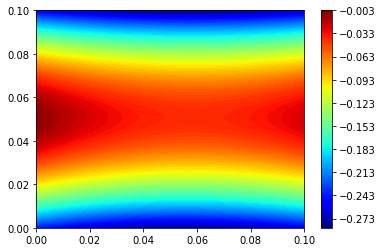

In [5]:
T_prev, dTdx, dTdy, d2Tdx2, d2Tdy2, f_prev = model(x_train, y_train)
X = np.reshape(x_train.detach().numpy(), (N_x, N_y))
Y = np.reshape(y_train.detach().numpy(), (N_x, N_y))
T = np.reshape(T_prev.detach().numpy(), (N_x, N_y))
F = np.reshape(f_prev.detach().numpy(), (N_x, N_y))
plt.contourf( X,Y,F, cmap =plt.cm.jet, levels = 100)
plt.colorbar()
plt.xlim(0, 0.1)

In [29]:
N_bc = 100
xb = 0.05
yb = 0.05
r = 0.025
x_train, y_train = xy_train_data(N_x, x_l, x_r, N_y, y_b, y_t, N_bc, r, xb, yb)

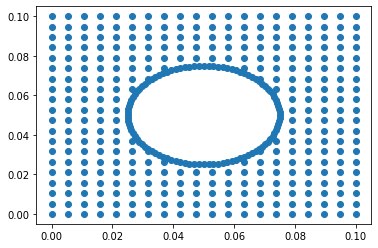

In [30]:
plt.scatter(x_train.detach().numpy(), y_train.detach().numpy())